In [1]:
import os
import json
import random
import numpy as np
from six.moves import range

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision

import lc_options
from utils import lc_utilities as utils
from rouge import Rouge
from similarity.normalized_levenshtein import NormalizedLevenshtein
from gensim.models import KeyedVectors
from scipy import spatial
word2vec = KeyedVectors.load_word2vec_format(
    'data/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [2]:
params = {
    'inputJson': "data/processed_data/processed_data.json",
    'useGPU': False,
    # A-Bot checkpoint
    'startFrom': "./checkpoints/rl_leven/abot_ep_19.vd",
    'qstartFrom': "./checkpoints/rl_leven/qbot_ep_19.vd",
    'beamSize': 5,
}

# RNG seed
manualSeed = 1597
random.seed(manualSeed)
torch.manual_seed(manualSeed)
if params['useGPU']:
    torch.cuda.manual_seed_all(manualSeed)

print('Loading json file: ' + params['inputJson'])
with open(params['inputJson'], 'r') as fileId:
    info = json.load(fileId)

wordCount = len(info['word2ind'])
# Add <START> and <END> to vocabulary
info['word2ind']['<START>'] = wordCount + 1
info['word2ind']['<END>'] = wordCount + 2
startToken = info['word2ind']['<START>']
endToken = info['word2ind']['<END>']
# Padding token is at index 0
vocabSize = wordCount + 3
print('Vocab size with <START>, <END>: %d' % vocabSize)

# Construct the reverse map
info['ind2word'] = {
    int(ind): word
    for word, ind in info['word2ind'].items()
}

Loading json file: data/processed_data/processed_data.json
Vocab size with <START>, <END>: 4952


In [3]:
def loadModel(params, agent='abot'):
    # should be everything used in encoderParam, decoderParam below
    encoderOptions = [
        'encoder', 'vocabSize', 'embedSize', 'rnnHiddenSize', 'numLayers',
        'useHistory', 'numRounds', 'dropout', 'useSumm'
    ]
    decoderOptions = [
        'decoder', 'vocabSize', 'embedSize', 'rnnHiddenSize', 'numLayers',
        'dropout'
    ]
    modelOptions = encoderOptions + decoderOptions

    mdict = None
    gpuFlag = params['useGPU']
    startArg = 'startFrom' if agent == 'abot' else 'qstartFrom'
    assert params[startArg], "Need checkpoint for {}".format(agent)

    if params[startArg]:
        print('Loading model (weights and config) from {}'.format(
            params[startArg]))

        if gpuFlag:
            mdict = torch.load(params[startArg])
        else:
            mdict = torch.load(params[startArg],
                map_location=lambda storage, location: storage)

        # Model options is a union of standard model options defined
        # above and parameters loaded from checkpoint
        modelOptions = list(set(modelOptions).union(set(mdict['params'])))
        for opt in modelOptions:
            if opt not in params:
                params[opt] = mdict['params'][opt]

            elif params[opt] != mdict['params'][opt]:
                # Parameters are not overwritten from checkpoint
                pass

    # Initialize model class
    encoderParam = {k: params[k] for k in encoderOptions}
    decoderParam = {k: params[k] for k in decoderOptions}

    encoderParam['startToken'] = encoderParam['vocabSize'] - 2
    encoderParam['endToken'] = encoderParam['vocabSize'] - 1
    decoderParam['startToken'] = decoderParam['vocabSize'] - 2
    decoderParam['endToken'] = decoderParam['vocabSize'] - 1

    if agent == 'abot':
        encoderParam['type'] = params['encoder']
        decoderParam['type'] = params['decoder']
        encoderParam['isAnswerer'] = True
        from lc.models.lc_answerer import Answerer
        model = Answerer(encoderParam, decoderParam)

    elif agent == 'qbot':
        encoderParam['type'] = params['qencoder']
        decoderParam['type'] = params['qdecoder']
        encoderParam['isAnswerer'] = False
        encoderParam['useSumm'] = False
        from lc.models.lc_questioner import Questioner
        model = Questioner(
            encoderParam,
            decoderParam,
            summSize=200)

    if params['useGPU']:
        model.cuda()

    if mdict:
        model.load_state_dict(mdict['model'])
        
    print("Loaded agent {}".format(agent))
    return model

In [4]:
ind_map = lambda words: np.array([info['word2ind'].get(word, info['word2ind']['UNK']) 
                                  for word in words], dtype='int64')

tokenize = lambda string: ['<START>'] + word_tokenize(string) + ['<END>']

to_str_gt = lambda w: str(" ".join([info['ind2word'][x] for x in filter(
        lambda x:x>0,w.data.cpu().numpy())]))[8:-6]

to_str_pred = lambda w, l: str(" ".join([info['ind2word'][x] for x in list( filter(
        lambda x:x>0,w.data.cpu().numpy()))][:l.data.cpu()[0]]))[8:]

def var_map(tensor):
    return Variable(tensor.unsqueeze(0), volatile=True)

In [5]:
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anest\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anest\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def string_conv(string):

    words = nltk.word_tokenize(string)
    words = [word.lower() for word in words if word.isalnum()]
    string = word_tokenize(' '.join(words))
    
    clear_seq = []
    for word in string:
        if (word not in stop_words):
            clear_seq.append(word)
            
    string = ' '.join(clear_seq)
    string_tokens = tokenize(string)
    string = ind_map(string_tokens)
    string_tensor = var_map(torch.from_numpy(string))
    string_lens = var_map(torch.LongTensor([len(string)]))
    
    return string_tensor, string_lens

In [7]:
def word2vec_transform(sequence):
    vectorized = []
    words = word_tokenize(sequence)
    seq_tokens = [word.lower() for word in words if word.isalnum()]
    
    for word in seq_tokens:
        try:
            vectorized.append(word2vec[word])
        except:
            vectorized.append(np.zeros(300,))
            
    return np.array(vectorized)

def similarity_cosine(vec1, vec2):
    cosine_distance = spatial.distance.cosine(vec1, vec2)
    return 1-cosine_distance


In [8]:
doc_data = json.load(open('data/generated_data/gen_dataset.json'))['data']['dialogs']
summ_data = json.load(open('data/generated_data/summary_dataset.json'))

eval_data = []

for doc in doc_data:
    eval_data.append({
        'doc': doc['document'],
        'summ': summ_data[doc['summary']]
    })
    
eval_data = eval_data[117:]

In [27]:
summ_data[doc_data[118]['summary']]

'Kartagener syndrome is a type of p that is also characterized by situs inversus totalis (mirror-image reversal of internal organs ). The signs and symptoms vary but may include neonatal respiratory distress; frequent lung, sinus and middle ear infections beginning in early childhood; and infertility.   In people affected by situs inversus totalis, the internal organs including the heart, liver, spleen and intestine are on the opposite side of the body. Although the internal organs are abnormally placed, this condition typically does not cause any health problems. Kartagener syndrome can be caused by changes ( mutations ) in many different genes . These genes encode proteins that are important to the structure and function of cilia. Cilia are tiny, hair-like structures that are found on the surface of cells in various parts of the body such as the lining of the airway, the reproductive system, and other organs . Mutations in these genes cause the cilia to be either immotile (unable to 

In [10]:
numRounds = 10
beamSize = 5

summary_tensor, summary_lens = string_conv(summ_data[doc_data[118]['summary']])
document_tensor, document_lens = string_conv(doc_data[118]['document'])

aBot = None
qBot = None

# load aBot
if params['startFrom']:
    aBot = loadModel(params, 'abot')
    assert aBot.encoder.vocabSize == vocabSize, "Vocab size mismatch!"
    aBot.eval()
    
# load qBot
if params['qstartFrom']:
    qBot = loadModel(params, 'qbot')
    assert qBot.encoder.vocabSize == vocabSize, "Vocab size mismatch!"
    qBot.eval()


# prepare for dialogue
if aBot:
    aBot.eval(), aBot.reset()
    aBot.train(), aBot.reset()
    aBot.observe(-1, summary=summary_tensor, summaryLens=summary_lens, document=document_tensor,
                    documentLens=document_lens)

if qBot:
    qBot.eval(), qBot.reset()
    qBot.observe(-1, document=document_tensor,
                    documentLens=document_lens)
summ, summ_lens = qBot.predictSummary(inference='greedy')
print('S%s:' %-1, to_str_pred(summ[0], summ_lens))

# dialogue before summ generation
for round in range(numRounds):
    questions, quesLens = qBot.forwardDecode(
        beamSize=beamSize, inference='greedy')
    qBot.observe(round, ques=questions, quesLens=quesLens)
    aBot.observe(round, ques=questions, quesLens=quesLens)
    answers, ansLens = aBot.forwardDecode(
        beamSize=beamSize, inference='greedy')
    aBot.observe(round, ans=answers, ansLens=ansLens)
    qBot.observe(round, ans=answers, ansLens=ansLens)
    
    summ, summ_lens = qBot.predictSummary(inference='sample')
    print('Q%s:' %round, to_str_pred(questions[0], quesLens))
    print('A%s:' %round, to_str_pred(answers[0], ansLens))

print('S%s:' %-1, to_str_pred(summ[0], summ_lens))

C:\Users\anest\AppData\Local\Temp\ipykernel_5316\4003069411.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(tensor.unsqueeze(0), volatile=True)


Loading model (weights and config) from ./checkpoints/rl_leven/abot_ep_19.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent abot
Loading model (weights and config) from ./checkpoints/rl_leven/qbot_ep_19.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent qbot
S-1: making proteins signs symptoms experts noticeable sign disease people making proteins regain normal mistakenly gallbladder produce indigestion course bloating gallbladder heartburn cystic signs symptoms making proteins affect gas system digestive system however been diagnosed making proteins has middle symptoms belly cholecystectomy hydroxyurea skin general aggressive belly hear secretions thin organs help making proteins anesthesia plug long air lungs cause signs symptoms marked facial psychiatric secretions organs 7 wheezing surgeon clumps bile follow location injuries hydroxyurea itchy passages removed position secretions organs during overview plug long digestive relatives skin absence percentage rasagilin

c:\Users\anest\Desktop\lc_mas_torch\lc\models\decoders\lc_summ.py:176: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1647.)
  sample.data.masked_fill_(
c:\Users\anest\Desktop\lc_mas_torch\lc\models\decoders\lc_summ.py:184: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1647.)
  unitColumn.masked_fill_(mask[:, t], 0)


Q0: how is gonorrhea diagnosed ?
A0: you also need to get tested if you have any symptoms of gonorrhea testing is very important because women with untreated gonorrhea can develop serious health problems if you are
Q1: what is the specialized available to males with klinefelter ?
A1: you can take steps to help prevent or delay type 2 diabetes by losing weight if you are overweight eating fewer calories and being more physically active talk with your
Q2: what do you do for rheumatoid arthritis ?
A2: the following organizations are good resources for information on kidney disease national institute of diabetes and digestive and kidney disease national kidney foundation american kidney UNK american UNK society health
Q3: what can you do for rheumatoid arthritis ?
A3: most cases of acute bronchitis get better without treatment usually within a couple of weeks because most cases of bronchitis are caused by viral first have a relative such as
Q4: what can cause hypoglycemia ?
A4: hypoglycemi

In [11]:
numRounds = 10
beamSize = 5

summs_eval = []
rouge_1 = [[],[],[],[],[],[],[],[],[],[]]
rouge_2 = [[],[],[],[],[],[],[],[],[],[]]
rouge_l = [[],[],[],[],[],[],[],[],[],[]]
leven = [[],[],[],[],[],[],[],[],[],[]]
word2v = [[],[],[],[],[],[],[],[],[],[]]

ques = []
ans = []

for eval in eval_data:
    # load data
    summary_tensor, summary_lens = string_conv(eval['summ'])
    document_tensor, document_lens = string_conv(eval['doc'])
    
    aBot = None
    qBot = None
    
    # load aBot
    if params['startFrom']:
        aBot = loadModel(params, 'abot')
        assert aBot.encoder.vocabSize == vocabSize, "Vocab size mismatch!"
        aBot.eval()
        
    # load qBot
    if params['qstartFrom']:
        qBot = loadModel(params, 'qbot')
        assert qBot.encoder.vocabSize == vocabSize, "Vocab size mismatch!"
        qBot.eval()


    # prepare for dialogue
    if aBot:
        aBot.eval(), aBot.reset()
        aBot.train(), aBot.reset()
        aBot.observe(-1, summary=summary_tensor, summaryLens=summary_lens, document=document_tensor,
                        documentLens=document_lens)

    if qBot:
        qBot.eval(), qBot.reset()
        qBot.observe(-1, document=document_tensor,
                        documentLens=document_lens)
    
    # dialogue before summ generation
    for round in range(numRounds):
        questions, quesLens = qBot.forwardDecode(
            beamSize=beamSize, inference='greedy')
        qBot.observe(round, ques=questions, quesLens=quesLens)
        aBot.observe(round, ques=questions, quesLens=quesLens)
        answers, ansLens = aBot.forwardDecode(
            beamSize=beamSize, inference='greedy')
        aBot.observe(round, ans=answers, ansLens=ansLens)
        qBot.observe(round, ans=answers, ansLens=ansLens)
        summ, summ_lens = qBot.predictSummary(inference='greedy')
        
        ques.append(to_str_pred(questions[0], quesLens))
        ans.append(to_str_pred(answers[0], ansLens))
        rouge_scores = Rouge().get_scores(eval['summ'], to_str_pred(summ[0], summ_lens), avg=True)
        rouge_1[round].append(rouge_scores['rouge-1']['f'] * 100)
        rouge_2[round].append(rouge_scores['rouge-2']['f'] * 100)
        rouge_l[round].append(rouge_scores['rouge-l']['f'] * 100)
        
        leven[round].append(100*(1 -  NormalizedLevenshtein().distance(eval['summ'],  to_str_pred(summ[0], summ_lens))))
        word2v[round].append(100* (similarity_cosine(word2vec_transform(eval['summ']).mean(axis=0),word2vec_transform(to_str_pred(summ[0], summ_lens)).mean(axis=0))))

    summs_eval.append({
        'gt': eval['summ'],
        'doc': eval['doc'],
        'gen': to_str_pred(summ[0], summ_lens)
    })

C:\Users\anest\AppData\Local\Temp\ipykernel_5316\4003069411.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(tensor.unsqueeze(0), volatile=True)


Loading model (weights and config) from ./checkpoints/rl_leven/abot_ep_19.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent abot
Loading model (weights and config) from ./checkpoints/rl_leven/qbot_ep_19.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent qbot
Loading model (weights and config) from ./checkpoints/rl_leven/abot_ep_19.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent abot
Loading model (weights and config) from ./checkpoints/rl_leven/qbot_ep_19.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent qbot
Loading model (weights and config) from ./checkpoints/rl_leven/abot_ep_19.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent abot
Loading model (weights and config) from ./checkpoints/rl_leven/qbot_ep_19.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent qbot
Loading model (weights and config) from ./checkpoints/rl_leven/abot_ep_19.vd
Encoder: hre-ques-lateim-hist
Decoder: gen
Loaded agent abot
Loading model (weights and config)

In [12]:
ques_sum_len = 0
words = []
for an in ques:
    ques_sum_len += len(an.split())
    for w in an.split():
        words.append(w)
        
        
print(len(words))
print(len(set(words)))
print(len(set(ques)))
print(ques_sum_len / 390)

3092
80
35
7.9282051282051285


In [13]:
ans_sum_len = 0
words = []
for an in ans:
    ans_sum_len += len(an.split())
    for w in an.split():
        words.append(w)
        
        
print(len(words))
print(len(set(words)))
print(len(set(ans)))
print(ans_sum_len / 390)

11133
300
29
28.546153846153846


In [14]:
print(len(summs_eval))

sss = []
for sm in summs_eval:
    sss.append(sm['gen'])

39


In [15]:
set(sss)

{'asthma hormones artery heart spread menopause light gas cigarette chronic widespread therapy disease deep talking artery heart defect eliminate signs symptoms assessment problems risk during abnormalities location therapy diabetes source two trait air paralyzed combined source risk stent mold test paroxysmal eyelids macula plug pollen trait air paroxysmal symptom breath hyperactivity combined start alzheimer start alzheimer nitric lives weather face critical combined pumping tension start alzheimer paroxysmal dies lungs risk mixed foot asthma risk puberty maintain chest read tms success ect lungs position special oxide autosomal paroxysmal 30 brain cigarette cause newer breathing problems spells source autosomal spells pulse wood oximetry fresh collected urethra lesion collect diagnosis test heart face amount collected urethra relationship breath paroxysmal smoking collected urethra paroxysmal indicate inflammation macula plug topical concentrates test temperature european asthma att

In [16]:
len(set(sss))

9

In [17]:
len(ques)

390

In [18]:
len(set(ques))

35

In [19]:
print(set(ques))

{'what test do you use to cure chickenpox ?', 'what happens to the muscles and tissues supporting the inner wall of the body ?', 'what is another name for nonsteroidal hypertension ?', 'what is another name for nonsteroidal drugs ?', 'what is binge eating disorder ?', 'what does the UNK available to males disease ?', 'how to prevent atherosclerosis ?', 'what is the treatment for cystic fibrosis ?', 'what are the clumps of rheumatoid arthritis ?', 'what is the specialized available to males with klinefelter ?', 'what is epilepsy ?', 'how do you do for rheumatoid arthritis ?', 'what can you do to help with klinefelter ?', 'how to prevent lung cancer ?', 'what can you do for rheumatoid arthritis ?', 'what does the causes available to males disease ?', 'what happens to the causes of klinefelter cancer by ?', 'what is the most commonly fat cause of developmental and intellectual ?', 'how is gonorrhea diagnosed ?', 'how do you diagnose anxiety ?', 'how common is cystic fibrosis ?', 'how do y

In [20]:
print(ques[0].split())

['what', 'are', 'the', 'causes', 'of', 'pulmonary', 'hypertension', '?']


In [21]:
words = []

for q in ques:
    for w in q.split():
        words.append(w)
        
print(len(words))

3092


In [22]:
len(set(words))

80

In [23]:
rouge_scores = []
levenshtein_similarities = []
word2vec_similarities = []


for pair in summs_eval:
    rouge_scores.append(Rouge().get_scores(pair['gt'], pair['gen'], avg=True))
    levenshtein_similarities.append(1 -  NormalizedLevenshtein().distance(pair['gt'], pair['gen']))
    word2vec_similarities.append(similarity_cosine(word2vec_transform(pair['gt']).mean(axis=0),word2vec_transform(pair['gen']).mean(axis=0)))
    
common_words = []
for pair in summs_eval:
    gt_summ = pair['gt'].lower()
    gen_summ = pair['gen'].lower()
    for word in pair['gen'].split():
        if word in pair['gt'].split():
            common_words.append(word)

rouge_f1 = []
rouge_f2 = []
rouge_fl = []

for score in rouge_scores:
    rouge_f1.append(score['rouge-1']['f'])
    rouge_f2.append(score['rouge-2']['f'])
    rouge_fl.append(score['rouge-l']['f'])

print(sum(levenshtein_similarities) / len(levenshtein_similarities)* 100)
print('------------------------------')
print(sum(word2vec_similarities) / len(word2vec_similarities)*100)
print('------------------------------')
print(sum(rouge_f1) / len(rouge_f1)* 100)
print('------------------------------')
print(sum(rouge_f2) / len(rouge_fl) *100) 
print('------------------------------')
print(sum(rouge_fl) / len(rouge_fl)* 100)
            

22.475807725248792
------------------------------
78.02008894946894
------------------------------
3.971121399554488
------------------------------
0.0
------------------------------
3.4840668657979363


In [24]:
print(max(levenshtein_similarities))
print(min(levenshtein_similarities))
print(sum(levenshtein_similarities) / len(levenshtein_similarities)* 100)
print('------------------------------')
print(max(word2vec_similarities))
print(min(word2vec_similarities))
print(sum(word2vec_similarities) / len(word2vec_similarities)*100)
print('------------------------------')
print(max(rouge_f1))
print(min(rouge_f1))
print(sum(rouge_f1) / len(rouge_f1)* 100)
print('------------------------------')
print(max(rouge_f2))
print(min(rouge_f2))
print(sum(rouge_f2) / len(rouge_fl) *100) 
print('------------------------------')
print(max(rouge_fl))
print(min(rouge_fl))
print(sum(rouge_fl) / len(rouge_fl)* 100)

0.2679611650485437
0.08620689655172409
22.475807725248792
------------------------------
0.8871382618603975
0.5451210950892944
78.02008894946894
------------------------------
0.09259258768904347
0.0
3.971121399554488
------------------------------
0.0
0.0
0.0
------------------------------
0.07407406917052503
0.0
3.4840668657979363


PER ROUNG

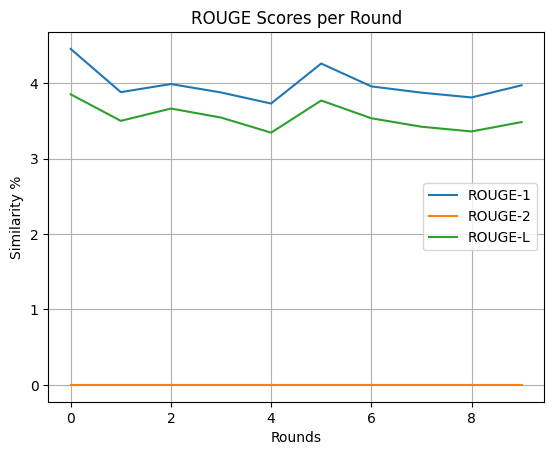

In [25]:
r1_plot = []
r2_plot = []
rl_plot = []
leven_plot = []
word2v_plot = []

for i in range(10):
    r1_plot.append(sum(rouge_1[i]) / len(rouge_1[i]))
    r2_plot.append(sum(rouge_2[i]) / len(rouge_2[i]))
    rl_plot.append(sum(rouge_l[i]) / len(rouge_l[i]))
    leven_plot.append(sum(leven[i]) / len(leven[i]))
    word2v_plot.append(sum(word2v[i]) / len(word2v[i]))
    
plot_data = {'ROUGE-1': r1_plot,'ROUGE-2': r2_plot,'ROUGE-L':rl_plot,}


import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for dat in plot_data.keys():
    ax.plot([0,1,2,3,4,5,6,7,8,9], plot_data[dat], label=dat)
ax.set(ylabel='Similarity %', xlabel='Rounds', title='ROUGE Scores per Round')
ax.grid()
    
plt.legend()
    
plt.show()


    # 

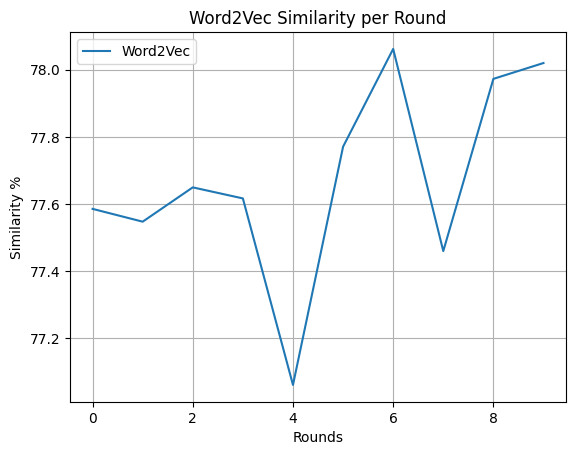

In [26]:
plot_data = {'Word2Vec':word2v_plot}
# 'Word2Vec':word2v_plot
# 'Norm Levenshtein':leven_plot, 

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for dat in plot_data.keys():
    ax.plot([0,1,2,3,4,5,6,7,8,9], plot_data[dat], label=dat)
ax.set(ylabel='Similarity %', xlabel='Rounds', title='Word2Vec Similarity per Round')
ax.grid()
    
plt.legend()
    
plt.show()